# Part 1: Similarity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm
from collections import OrderedDict

np.set_printoptions(precision=2, suppress=True)

In [2]:
with open('newsgroup_data.yaml', 'r') as file:
    newsgroup_data = OrderedDict(yaml.load(file, Loader=yaml.FullLoader))

In [3]:
def convert_to_vector(x):
    x_array = np.zeros(N)
    x_array[np.array(list(x.keys())) - 1] = np.array(list(x.values()))
    return x_array

# Find the maximum word_id
N = max(
    int(word_id)  # Convert keys to integers
    for newsgroup, articles in newsgroup_data.items()
    for article, words in articles.items()
    for word_id in words.keys()
)
print(N)


61067


In [4]:
# Convert newsgroup dictionaries into matrices
for newsgroup, articles in newsgroup_data.items():
    # Convert articles into a list of vectors
    article_vectors = [
        convert_to_vector(words)
        for _, words in articles.items()
    ]
    
    # Stack article vectors into a matrix
    newsgroup_data[newsgroup] = np.vstack(article_vectors)

In [5]:
print(newsgroup_data)

OrderedDict({'alt.atheism': array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'comp.graphics': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'comp.os.ms-windows.misc': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'comp.sys.ibm.pc.hardware': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0.

In [6]:
def jaccard_similarity(x, y):
    intersection = np.sum(np.minimum(x, y))
    union = np.sum(np.maximum(x, y))
    
    return intersection / union

def l2_similarity(x, y):
    return -np.linalg.norm(x - y)

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [7]:
def heatmap(similarity_function, data):
    keys = list(data.keys())
    n = len(keys)
    matrix = np.zeros((n, n))
    
    for i in tqdm(range(n)):
        for j in range(n):
            
            # Use np.mean on the double list comprehension
            matrix[i, j] = np.mean([
                similarity_function(article1, article2)
                for article1 in data[keys[i]]
                for article2 in data[keys[j]]
            ])
    
    plt.imshow(matrix, cmap='hot', interpolation='nearest')
    plt.show()
    return matrix

100%|██████████| 20/20 [00:46<00:00,  2.32s/it]


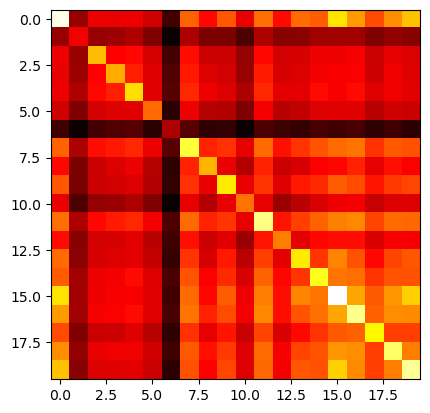

In [8]:
matrix = heatmap(jaccard_similarity, newsgroup_data)

100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


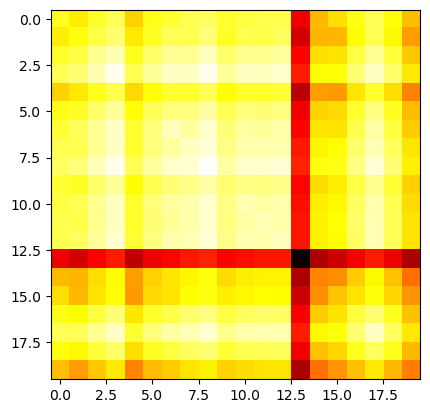

In [9]:
matrix = heatmap(l2_similarity, newsgroup_data)

100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


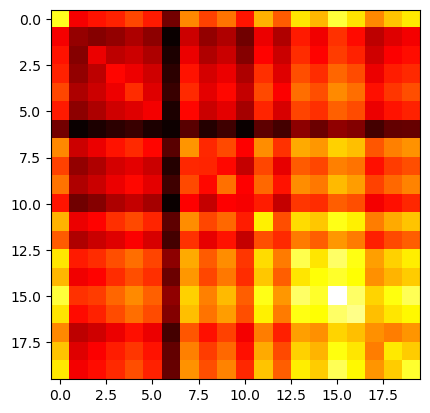

In [10]:
matrix = heatmap(cosine_similarity, newsgroup_data)

In [12]:
keys = list(newsgroup_data.keys())
print(keys[15])
# print(np.argmax(matrix, axis=0))

soc.religion.christian


# Part 2: Dimension Reduction

In [8]:
def nns(article, dataset):
    best_group = None
    best_sim = -np.inf
    for newsgroup, articles in dataset.items():
        similarities = [
            cosine_similarity(article, other_article)
            for other_article in articles
        ]
        if np.max(similarities) > 1 - 1e-8:
            similarities.remove(np.max(similarities))
        
        max_sim = np.max(similarities)
        if max_sim > best_sim:
            best_sim = max_sim
            best_group = newsgroup
    return best_group

In [9]:
def get_frac_articles_close(data):
    frac_articles_close = np.zeros((len(data), len(data)))
    for i in tqdm(range(len(data))):
        for j in range(len(data)):
            frac_articles_close[i, j] = np.mean([
                nns(article, data) == keys[j]
                for article in data[keys[i]]
            ])

    return frac_articles_close

def classification_error(frac_articles_close):
    return 1 - np.mean(frac_articles_close.diagonal())

100%|██████████| 20/20 [06:07<00:00, 18.36s/it]


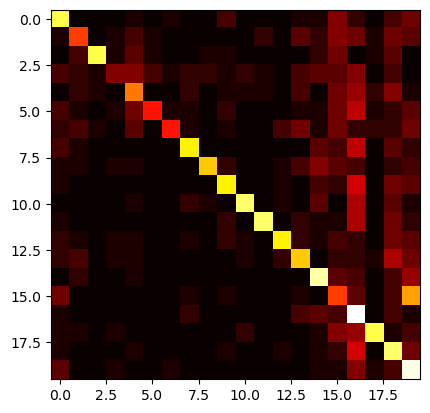

In [13]:
frac_articles_close = get_frac_articles_close(newsgroup_data)
plt.imshow(frac_articles_close, cmap='hot', interpolation='nearest')

In [14]:
classification_error(frac_articles_close)

0.5439999999999999

In [15]:
def data_normal_transformation(data, d):
    M = np.random.normal(size=(N, d))
    data_transformed = OrderedDict()
    
    for newsgroup, articles in data.items():
        data_transformed[newsgroup] = articles @ M

    return data_transformed

def data_uniform_hypercube(data, d):
    M = np.random.choice([-1, 1], size=(N, d))
    data_transformed = OrderedDict()
    
    for newsgroup, articles in data.items():
        data_transformed[newsgroup] = articles @ M

    return data_transformed

def data_uniform_string(data, d):
    M = np.random.choice([0, 1], size=(N, d))
    data_transformed = OrderedDict()
    
    for newsgroup, articles in data.items():
        data_transformed[newsgroup] = articles @ M

    return data_transformed

In [16]:
def plot_heatmaps(matrices, fn_name, ds):
    # Create a figure and 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))  # 2 rows, 2 columns
    axes = axes.flatten()  # Flatten the grid for easy iteration

    for i, matrix in enumerate(matrices):
        ax = axes[i]
        im = ax.imshow(matrix, cmap='hot', interpolation='nearest')
        ax.set_title(f'{fn_name} Transformation with d={ds[i]}')
        plt.colorbar(im, ax=ax)  # Add a colorbar for each subplot

    # If there are unused subplots, hide them
    for j in range(len(matrices), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
def get_frac_articles_close_with_reduction(dim_reduction):
    matrices = []
    for d in [10, 30, 60, 120]:
        data_transformed = dim_reduction(newsgroup_data, d)
        matrices.append(get_frac_articles_close(data_transformed))
    return matrices

In [17]:
matrices = get_frac_articles_close_with_reduction(data_normal_transformation)

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]


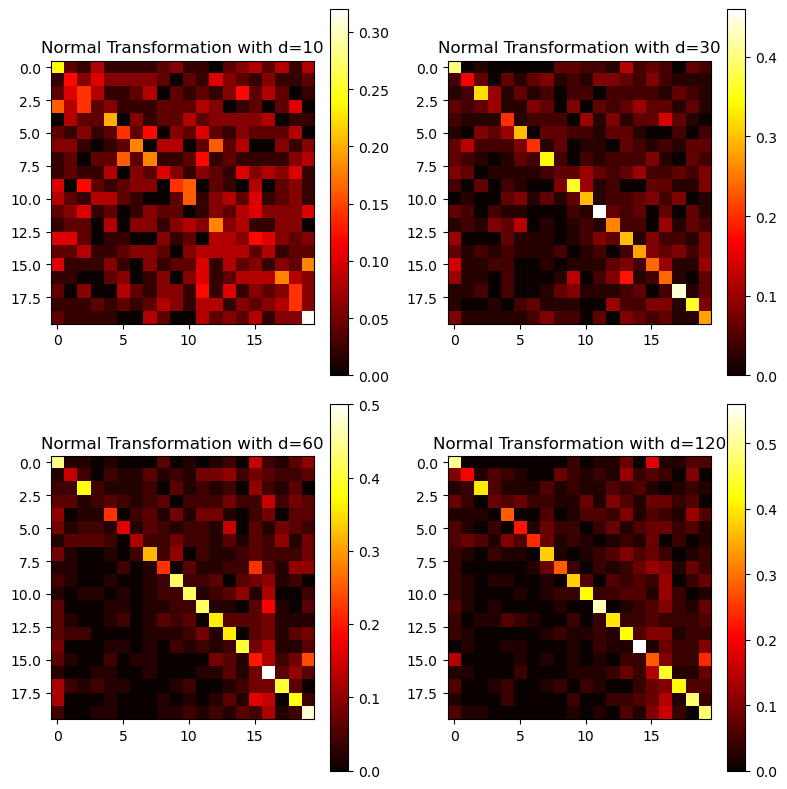

In [18]:
plot_heatmaps(matrices, 'Normal', [10, 30, 60, 120])

In [25]:
for i in range(len(matrices)):
    d = [10, 30, 60, 120][i]
    print(f'classification error for d = {d} is {classification_error(matrices[i])}')

classification error for d = 10 is 0.867
classification error for d = 30 is 0.72
classification error for d = 60 is 0.6809999999999999
classification error for d = 120 is 0.631


In [26]:
matrices_uniform_hypercube = get_frac_articles_close_with_reduction(data_uniform_hypercube)

100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


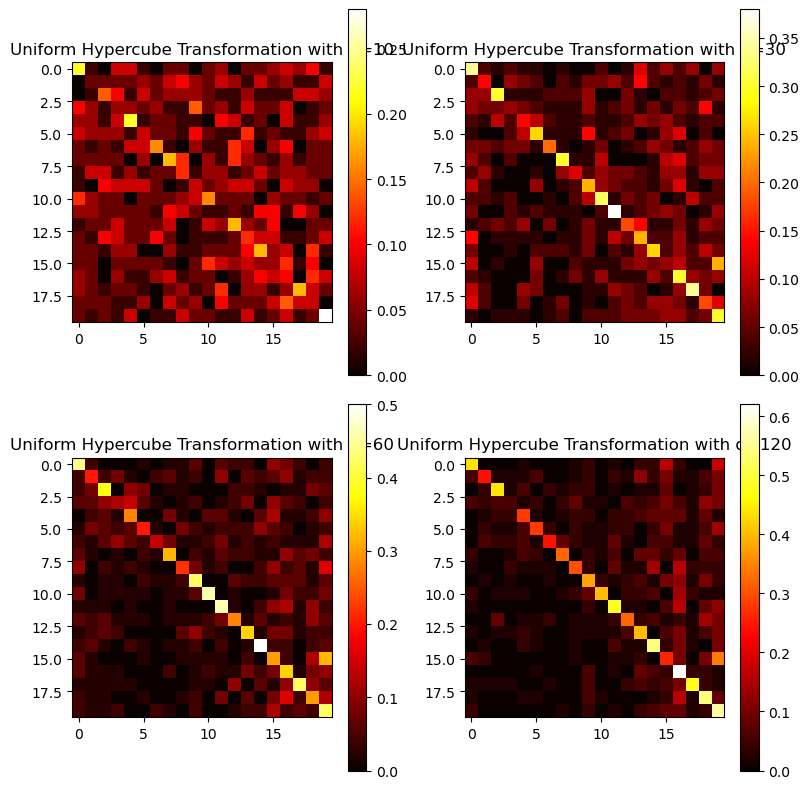

['classification error for 10: 0.867', 'classification error for 30: 0.765', 'classification error for 60: 0.673', 'classification error for 120: 0.621']


In [29]:
ds = [10, 30, 60, 120]
plot_heatmaps(matrices_uniform_hypercube, 'Uniform Hypercube', [10, 30, 60, 120])
print([f'classification error for {ds[i]}: {classification_error(matrices_uniform_hypercube[i])}' for i in range(len(matrices_uniform_hypercube))])

In [30]:
matrices_uniform_string = get_frac_articles_close_with_reduction(data_uniform_string)

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

['classification error for 10: 0.871', 'classification error for 30: 0.784', 'classification error for 60: 0.703', 'classification error for 120: 0.6629999999999999']


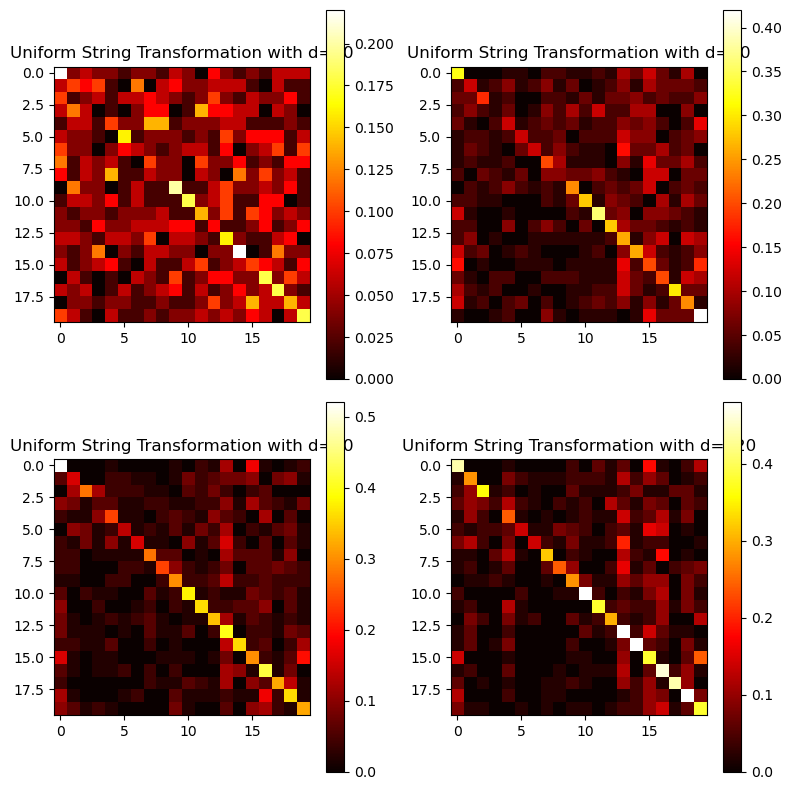

['classification error for 10: 0.871', 'classification error for 30: 0.784', 'classification error for 60: 0.703', 'classification error for 120: 0.6629999999999999']


In [32]:
plot_heatmaps(matrices_uniform_string, 'Uniform String', [10, 30, 60, 120])
print([f'classification error for {ds[i]}: {classification_error(matrices_uniform_string[i])}' for i in range(len(matrices_uniform_hypercube))])